### 1. 深度学习中的优化
### 2. 优化算法

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum  # 上面公式的\alpha
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [4]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

上面我们介绍了 SGD、Momentum、AdaGrad、Adam 几种方法，那么用哪种方法好呢？非常遗憾，（目前）并不存在能在所有问题中都表现良好的方法。这几种方法各有各的特点，都有各自擅长解决的问题和不擅长解决的问题。虽然具有自适应学习率的算法（如 RMSProp）表现得相当鲁棒，但没有哪个算法能脱颖而出。

### 3. 权重的初始值

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

In [7]:
def draw_output(w, activation_func):
    # 随机生成200个数据
    input_data = np.random.randn(200, 100)
    # 5层隐藏层
    hidden_layer_size = 5
    activations = {}  # 用来保存激活值的结果

    x = input_data

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        a = np.dot(x, w)

        activations[i] = activation_func(a)

    # 绘制直方图
    plt.figure(figsize=(12, 4))
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1) # nrows=1子图的行数，这里设为 1（所有子图水平排列）。ncols=len(activations)子图的列数。
        # index=i+1, 当前子图的位置索引（从 1 开始计数，不是从 0 开始）
        plt.title(str(i+1) + "-layer")
        if i != 0:
            plt.yticks([], []) # 不显示y轴刻度
        plt.ylim(0, 2000)
        plt.hist(a.flatten(), 30, range=(0,1))
        # flatten()将矩阵展平为一维数组, 30个bin（柱子）, 数据范围限制在[0,1]区间
    plt.show()

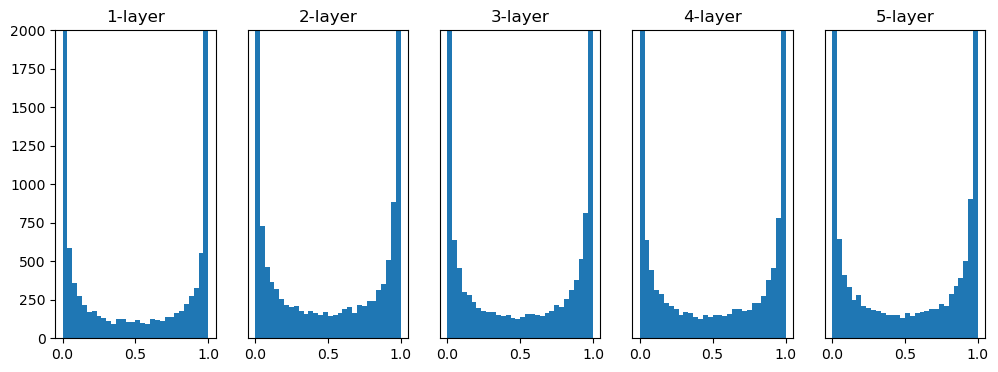

In [8]:
# 起初，我们使用的是标准差为 1 的正态分布初始化权重。
# 各隐藏层的神经元数为100
node_num = 100
w = np.random.randn(node_num, node_num)
draw_output(w, sigmoid)

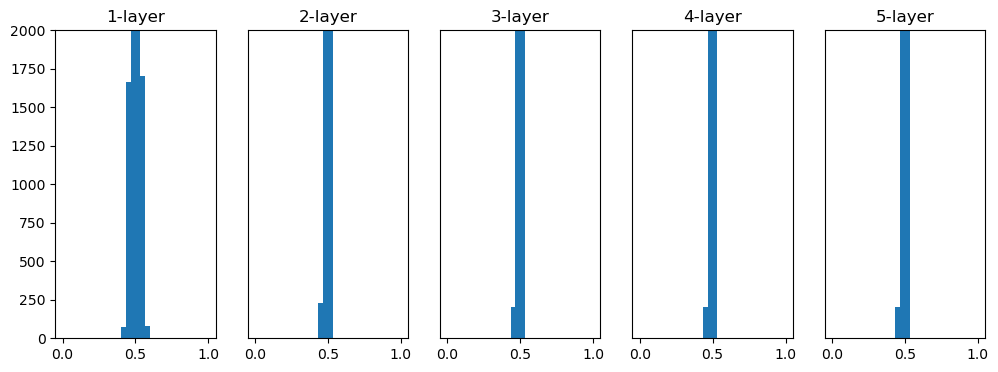

In [9]:
# 下面，将权重的标准差设为 0.01，进行相同的实验。
# 改变权重初始值的标准差为0.01
w = np.random.randn(node_num, node_num) * 0.01
draw_output(w, sigmoid)

但是，激活值的分布有所偏向，说明在表现力上会有很大问题。因为如果有多个神经元都输出几乎相同的值，那它们就没有存在的意义了。例如，如果 100 个神经元都输出几乎相同的值，那么也可以由 1 个神经元来表达基本相同的事情。因此，激活值在分布上有所偏向会出现“表现力受限”的问题。

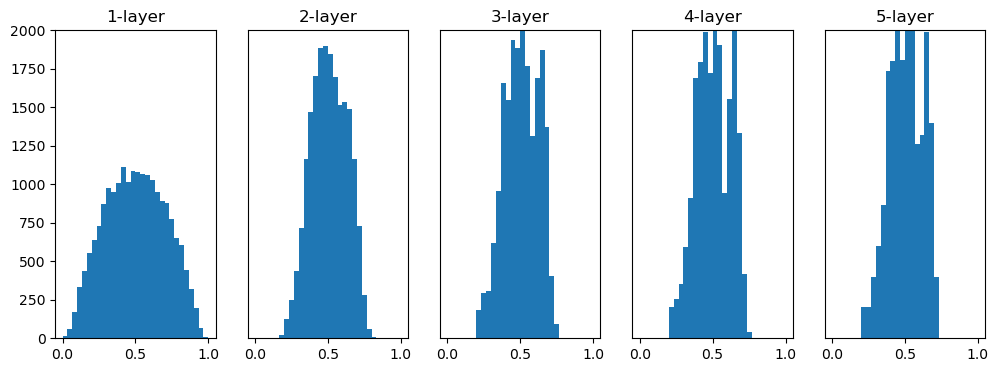

In [10]:
# 如果我们将权重的标准差设为 0.1，再次进行实验，会发现输出数值集中的情况改善许多。
# 改变权重初始值的标准差为0.1
w = np.random.randn(node_num, node_num) * 0.1
draw_output(w, sigmoid)

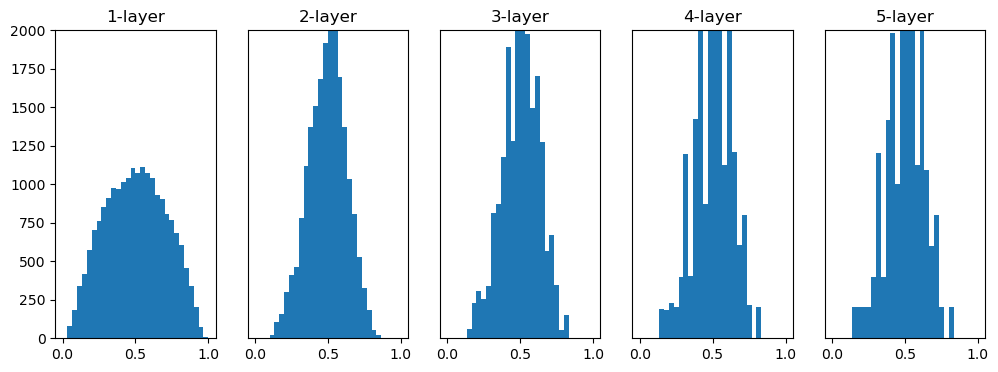

In [11]:
# uniform distribution
w = np.random.uniform(-np.sqrt(6.0/200), np.sqrt(6.0/200), (node_num, node_num))
draw_output(w, sigmoid)

还有一种简化的 Xavier 实现方式是，只使用了前一层的输入节点进行计算。如果前一层的节点数为 $n$，则权重初始值使用标准差为 $\frac{1}{\sqrt{n}}$ 的正态分布。

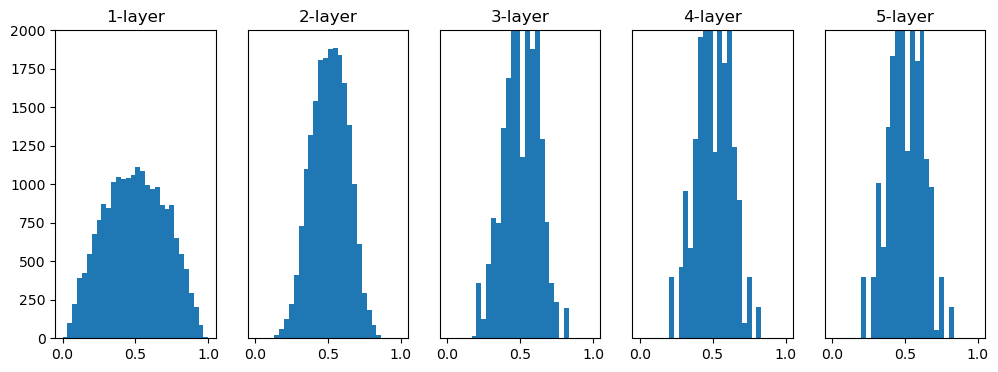

In [12]:
# normal distribution
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
draw_output(w, sigmoid)

Xavier 初始值是以激活函数是线性函数为前提而推导出来的。因为 sigmoid 函数和 tanh 函数左右对称，且中央附近可以视作线性函数，所以适合使用 Xavier 初始值。

但当激活函数使用 ReLU 时，一般推荐使用 ReLU 专用的初始值，也就是 [Kaiming He](https://arxiv.org/abs/1502.01852) 等人推荐的初始值，也称为“He 初始值”。当前一层的节点数为 $n$ 时，He 初始值使用标准差为 $\frac{2}{\sqrt{n}}$ 的高斯分布。当 Xavier 初始值是 $\frac{1}{\sqrt{n}}$ 时，（直观上）可以解释为，因为ReLU的负值区域的值为0，为了使它更有广度，所以需要 2 倍的系数。

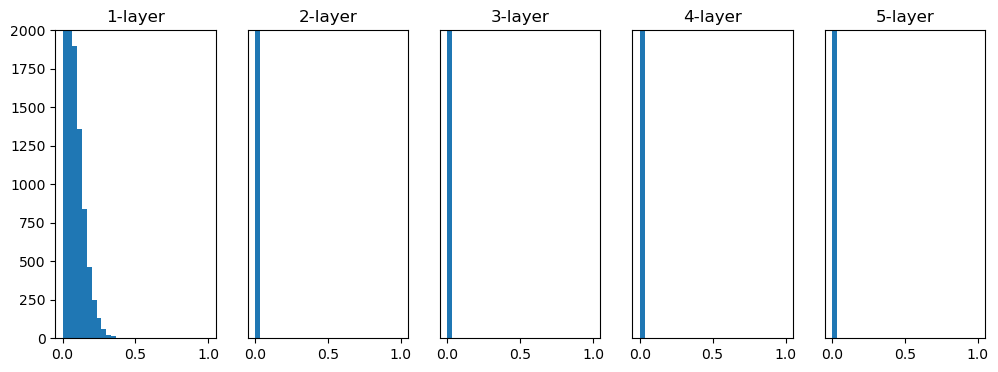

In [13]:
# std = 0.01
w = np.random.randn(node_num, node_num) * 0.01
draw_output(w, ReLU)

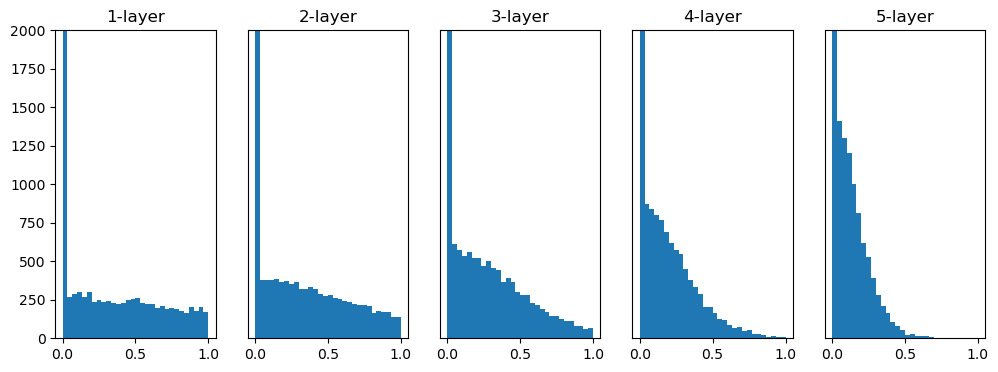

In [14]:
# Xavier initialization
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
draw_output(w, ReLU)

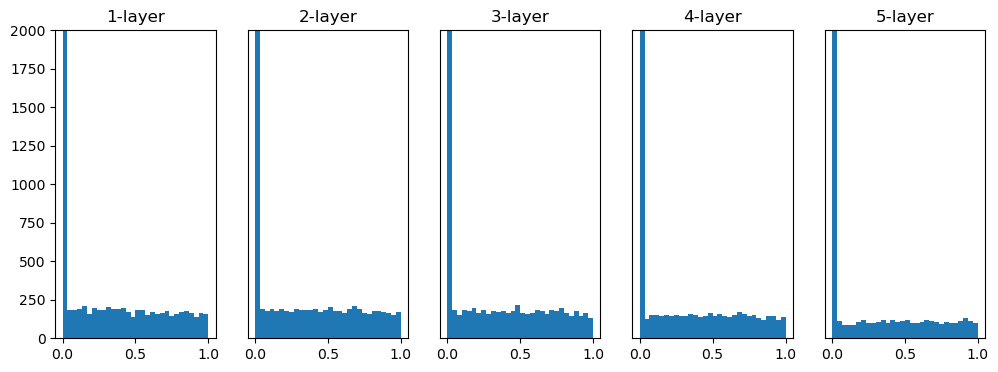

In [15]:
# He initialization
w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
draw_output(w, ReLU)

总结一下，当激活函数使用 ReLU 时，权重初始值使用 He 初始值，当激活函数为 sigmoid 或 tanh 等 S 型曲线函数时，初始值使用 Xavier 初始值。

在神经网络的学习中，权重初始值非常重要，很多时候权重初始值的设定关系到神经网络的学习能否成功。

### 4. [Batch Normalization](https://arxiv.org/abs/1502.03167)

Batch Normalization 由 Ioffe 和 Szegedy 于 2015 年提出，算法的思路是调整各层的激活值分布使其拥有适当的广度。算法以进行学习时的 mini-batch 为单位进行正规化，使数据分布的均值为 0、方差为 1。如下所示，

$$ \begin{aligned}
\mu_B &\leftarrow \frac{1}{m} \sum_{i=1}^m{x_i} \\
\sigma_B^2 &\leftarrow \frac{1}{m} \sum_{i=1}^m{(x_i-\mu_B)^2} \\
\hat x_i &\leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} \\
\end{aligned}$$

针对 mini-batch 的 $m$ 个输入数据的集合 $B = \{x_1, x_2, . . . , x_m\}$ 求均值 $\mu_B$ 和方差 $\sigma_B^2$。然后，对输入数据进行均值为 0、方差为 1（合适的分布）的正规化。$\epsilon$ 是一个微小值（例如，10e-7），它是为了防止出现除以 0 的情况。

接着，Batch Norm 层会对正规化后的数据进行缩放和平移变换，表示如下：

$$ y_i \leftarrow \gamma \hat x_i + \beta $$

其中，$\gamma$ 和 $\beta$ 是可学习参数，初始值 $\gamma=1$， $\beta=0$

### 5. 正则化
### L2正则化

L2 正则化，也称为权值衰减（Weight Decay）或权重衰减，是一直以来经常被使用的一种抑制过拟合的方法。很多过拟合原本就是因为权重参数取值过大才发生的，该方法通过在学习的过程中对大的权重进行惩罚，来抑制过拟合。

为损失函数加上权重的平方范数（L2 范数），就可以抑制权重变大。将权重记为 $W$，L2 范数的权值衰减就是 $\frac{1}{2}\lambda W^2$，然后将这个$\frac{1}{2}\lambda W^2$ 加到损失函数上。这里，$\lambda$ 是控制正则化强度的超参数。$\lambda$ 设置得越大，对大的权重施加的惩罚就越重。

$$ J = L(\hat y, y) + \frac{1}{2}\lambda W^2 $$

$$ \frac{\partial J}{\partial W} = \frac{\partial L}{\partial W} + \lambda W $$

因此，

$$ W \leftarrow W - \eta (\frac{\partial L}{\partial W} + \lambda W) = (1 -\eta \lambda)W - \eta \frac{\partial L}{\partial W}$$

可以看到，加入权重衰减后会引起学习规则的修改，即在每步执行通常的梯度更新之前先收缩权重向量（将权重向量乘以一个常数因子）

### L1正则化

L1 正则化倾向于聚集网络的权重在相对少量的高重要度的连接上，而其它权重会被驱使向 0 接近。

$$ J = L(\hat y, y) + \lambda |W| $$

$$ \frac{\partial J}{\partial W} = \frac{\partial L}{\partial W} + \lambda \cdot sign(W) $$

其中 $sign$ 是符号函数

$$sign(w)=
\begin{cases}
1&w > 0 \\
0&w = 0 \\
-1&w < 0
\end{cases}$$


因此，

$$ W \leftarrow W - \eta (\frac{\partial L}{\partial W} + \lambda \cdot sign(W)) $$

所以 L1 正则的作用是使 $w$ 在每一次迭代时都减小（也可能是增大，这取决于sign(w)）一个常数 $\eta \lambda$，使其向 0 靠近。

### Dropout
可以将 Dropout 理解为，通过在学习过程中随机删除神经元，从而每一次都让不同的模型进行学习。并且在推理时，通过对神经元的输出乘以删除比例，可以取得模型的平均值。也就是说，可以理解成，Dropout 将集成学习的效果（模拟地）通过一个网络实现了。

In [18]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flag=True):
        if train_flag:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio 
            # *x.shape 是 Python 的 解包操作符（Unpacking Operator），用于将数组 x 的形状（shape）元组展开为独立参数传递给 np.random.rand。
            return x * self.mask # 逐元素乘法（Element-wise Multiplication）
        else:
            return x * (1.0 - self.dropout_ratio)  # 验证时修正, 计算交叉函数时需要修正目标值
        
    def backward(self, dout):
        return dout * self.mask

### 提前终止（Early Stopping

我们只要返回使验证集误差最低的参数设置，就可以获得验证集误差更低的模型（并且因此有希望获得更好的测试误差）。在每次验证集误差有所改善后，我们存储模型参数的副本。当训练算法终止时，我们返回这些参数而不是最新的参数。这种策略被称为提前终止（Early Stopping），这可能是深度学习中最简单最常用的正则化形式。

### 6. 超参数的验证

### 交叉验证(cross-validation)
交叉验证的主要缺点是增加了计算成本。现在我们要训练 k 个模型而不是单个模型，所以交叉验证的速度要比数据的单次划分大约慢 k 倍。

### 7. 评估指标与评分
**准确率**（Precision）度量的是被预测为正例的样本中有多少是真正的正例，也称为查准率：

$$ {\rm Precision} = \frac{TP}{TP + FP} $$

**召回率**（Recall）度量的是正类样本中有多少被预测为正类，也称为灵敏度（Sensitivity）、查全率、真正例率（true positive rate，TPR）：

$$ {\rm Recall} = \frac{TP}{TP + FN} $$

在优化召回率与优化准确率之间需要折中。如果你预测所有样本都属于正类，那么可以轻松得到完美的召回率，但是准确率会很低。与此相反，如果你的模型只将一个最确定的数据点预测为正类，其他点都预测为反类，那么准确率将会很完美，但是召回率会非常差。

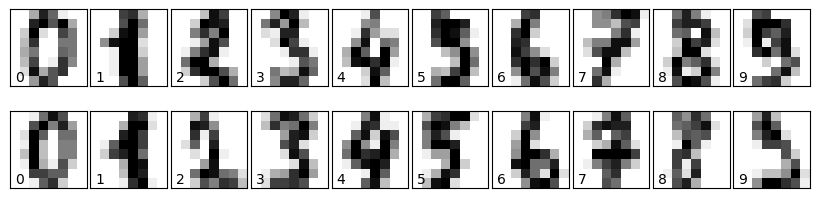

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split # 逻辑回归模型
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

digits = load_digits()

fig=plt.figure(figsize=(8,2))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
for i in range(20):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    ax.imshow(digits.images[i],cmap=plt.cm.binary,interpolation='nearest') # 显示图像，使用黑白颜色映射，最近邻插值
    ax.text(0,7,str(digits.target[i]))  # 在每个图像左上角(0,7)位置添加对应的数字标签
plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0) 
# train_test_split: 将数据集划分为 训练集（75%） 和 测试集（25%）。
# random_state=0: 设置随机种子，确保每次运行划分结果相同（可复现性）。

lr = LogisticRegression(solver='liblinear', multi_class='auto').fit(X_train, y_train)
# solver='liblinear': 使用 liblinear 优化算法（适用于小数据集和二分类/多分类）
# multi_class='auto': 自动选择多分类策略（此处为 OvR, One-vs-Rest）。
pred = lr.predict(X_test)

print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


E:\miniconda\envs\pydl\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


警告的解释:

'auto' 和 'ovr'（One-vs-Rest） 是传统的多分类策略，适用于 liblinear 等求解器。

'multinomial'（Softmax 回归）通常更优，但需要支持它的求解器（如 lbfgs）。

scikit-learn 未来将强制使用 'multinomial' 以简化 API，因此建议提前调整代码。

In [4]:
from sklearn.metrics import classification_report
# classification_report是scikit-learn 提供的一个用于评估分类模型性能的函数。
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



Macro Average（宏平均）: 对所有类别的 Precision/Recall/F1求算术平均（不区分样本数量）。

Weighted Average（加权平均）: 根据每个类别的样本数量加权平均。